In [ ]:
!pip install neat-python
!pip install Box2D

     |████████████████████████████████| 44 kB 1.7 MB/s 
     |████████████████████████████████| 1.3 MB 8.5 MB/s 


In [ ]:
!git clone https://github.com/ra2yama/softbody-tools.git tools

Cloning into 'tools'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 70 (delta 35), reused 52 (delta 19), pack-reused 0
Unpacking objects: 100% (70/70), done.


In [ ]:
# In case you need to reclone tools
!rm -rf tools

In [ ]:
#@title Visualize Module from NEAT-Python
# https://github.com/CodeReclaimers/neat-python/blob/master/examples/xor/visualize.py

from __future__ import print_function

import copy
import warnings

import graphviz
import matplotlib.pyplot as plt
import numpy as np


def plot_stats(statistics, ylog=False, view=False, filename='avg_fitness.svg'):
    """ Plots the population's average and best fitness. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    generation = range(len(statistics.most_fit_genomes))
    best_fitness = [c.fitness for c in statistics.most_fit_genomes]
    avg_fitness = np.array(statistics.get_fitness_mean())
    stdev_fitness = np.array(statistics.get_fitness_stdev())

    plt.plot(generation, avg_fitness, 'b-', label="average")
    plt.plot(generation, avg_fitness - stdev_fitness, 'g-.', label="-1 sd")
    plt.plot(generation, avg_fitness + stdev_fitness, 'g-.', label="+1 sd")
    plt.plot(generation, best_fitness, 'r-', label="best")

    plt.title("Population's average and best fitness")
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.grid()
    plt.legend(loc="best")
    if ylog:
        plt.gca().set_yscale('symlog')

    plt.savefig(filename)
    if view:
        plt.show()

    plt.close()


def plot_spikes(spikes, view=False, filename=None, title=None):
    """ Plots the trains for a single spiking neuron. """
    t_values = [t for t, I, v, u, f in spikes]
    v_values = [v for t, I, v, u, f in spikes]
    u_values = [u for t, I, v, u, f in spikes]
    I_values = [I for t, I, v, u, f in spikes]
    f_values = [f for t, I, v, u, f in spikes]

    fig = plt.figure()
    plt.subplot(4, 1, 1)
    plt.ylabel("Potential (mv)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, v_values, "g-")

    if title is None:
        plt.title("Izhikevich's spiking neuron model")
    else:
        plt.title("Izhikevich's spiking neuron model ({0!s})".format(title))

    plt.subplot(4, 1, 2)
    plt.ylabel("Fired")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, f_values, "r-")

    plt.subplot(4, 1, 3)
    plt.ylabel("Recovery (u)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, u_values, "r-")

    plt.subplot(4, 1, 4)
    plt.ylabel("Current (I)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, I_values, "r-o")

    if filename is not None:
        plt.savefig(filename)

    if view:
        plt.show()
        plt.close()
        fig = None

    return fig


def plot_species(statistics, view=False, filename='speciation.svg'):
    """ Visualizes speciation throughout evolution. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    species_sizes = statistics.get_species_sizes()
    num_generations = len(species_sizes)
    curves = np.array(species_sizes).T

    fig, ax = plt.subplots()
    ax.stackplot(range(num_generations), *curves)

    plt.title("Speciation")
    plt.ylabel("Size per Species")
    plt.xlabel("Generations")

    plt.savefig(filename)

    if view:
        plt.show()

    plt.close()


def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if graphviz is None:
        warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
        return

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled', 'shape': 'box', 'fillcolor': node_colors.get(k, 'lightgray')}
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled', 'fillcolor': node_colors.get(k, 'lightblue')}

        dot.node(name, _attributes=node_attrs)

    if prune_unused:
        connections = set()
        for cg in genome.connections.values():
            if cg.enabled or show_disabled:
                connections.add((cg.in_node_id, cg.out_node_id))

        used_nodes = copy.copy(outputs)
        pending = copy.copy(outputs)
        while pending:
            new_pending = set()
            for a, b in connections:
                if b in pending and a not in used_nodes:
                    new_pending.add(a)
                    used_nodes.add(a)
            pending = new_pending
    else:
        used_nodes = set(genome.nodes.keys())

    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled',
                 'fillcolor': node_colors.get(n, 'white')}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            #if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)

    return dot

In [ ]:
import Box2D  # The main library
from Box2D.b2 import (world, polygonShape, staticBody, dynamicBody, edgeShape, fixtureDef, circleShape)
from tools.environment import (Environment, RunTestbed)
from tools.softbody import (SoftBody, rect_positions, make_matrix, transpose_matrix)
import math

# Arbitrary Body
# fitness: |dx| ie abs(delta x)

m = [ # will come out transposed, because code interprets matrices as m[x][y]
  [0, 0, 0, 0, 0, 1, 1, 0],
  [0, 0, 0, 0, 0, 1, 1, 0],
  [0, 0, 0, 0, 0, 1, 1, 0],
  [0, 0, 0, 0, 0, 1, 1, 0],
  [0, 0, 0, 0, 1, 1, 1, 0],
  [0, 0, 0, 0, 1, 1, 1, 0],
  [0, 0, 0, 1, 1, 1, 1, 0],
  [0, 0, 1, 1, 1, 1, 1, 0],
  [1, 1, 1, 1, 1, 1, 1, 0],
  [1, 1, 1, 1, 1, 1, 1, 0],
]

# self.body = SoftBody.new_from_points((0, 5), rect_positions(5, 20, 1.5), 0.5, world)
# self.body = SoftBody.new_as_voxel((0, 5), transpose_matrix(m), 1.5, 0.5, world, intersecting=True)
# self.body = SoftBody.new_as_voxel((-20, 5), transpose_matrix(m), 1.5, 0.5, world, intersecting=True)

body_matrix = make_matrix(20, 2, 1)
# body_matrix = transpose_matrix(m)

# dummy world and body to determine number of input/output nodes
dummy_world = world(gravity=(0, -10), doSleep=True)
dummy = SoftBody.new_as_voxel((0, 0.5), body_matrix, 1.5, 0.5, dummy_world)

print("{} Muscle groups".format(len(dummy.muscle_group_extensions)))
io_size = len(dummy.muscle_group_extensions)

dummy.destroy_all(dummy_world)

class SampleEnv(Environment):
    def __init__(self, **kwargs):
        self.time = 0
        self.platform_length = 200
        self.xi = None
        self.index = 0
        self.a = 2
        super().__init__(world(gravity=(0, -10), doSleep=True), **kwargs) 
        
    def init_bodies (self, world):
        ground = world.CreateBody(
            shapes=edgeShape(vertices=[(-self.platform_length / 2, 0), (self.platform_length / 2, 0)])
        )

        self.body = SoftBody.new_as_voxel((0, 0.5), body_matrix, 1.5, 0.5, world)

        xi, _ = self.body.cells[0].GetWorldPoint((0, 0)) # tracks relative to one cell. Probably wiser to calculate center of mass.
        self.xi = xi
    
    def tick (self, world):
        self.time += 1
    
    def calc_fitness (self):
        xf, _ = self.body.cells[0].GetWorldPoint((0, 0))
        dx = xf - self.xi

        return abs(dx)

New Softbody with 63, masses, 320 springs, and 40 muscle groups
40 Muscle groups


In [ ]:
#@title Defining config file

with open('config-recurrent-trial-2', 'w') as file:
    file.write("""
   # NEAT configuration for the bit-sequence memory experiment.

# The `NEAT` section specifies parameters particular to the NEAT algorithm
# or the experiment itself.  This is the only required section.
[NEAT]
fitness_criterion   = max
fitness_threshold   = 60.0
pop_size            = 60
reset_on_extinction = 0

[DefaultGenome]
num_inputs              = {}
num_hidden              = 0
num_outputs             = {}
initial_connection      = partial_direct 0.8
feed_forward            = False
compatibility_disjoint_coefficient    = 1.0
compatibility_weight_coefficient      = 0.6
conn_add_prob           = 0.2
conn_delete_prob        = 0.2
node_add_prob           = 0.5
node_delete_prob        = 0.5
activation_default      = tanh
activation_options      = tanh
activation_mutate_rate  = 0.0
aggregation_default     = sum
aggregation_options     = sum
aggregation_mutate_rate = 0.0
bias_init_mean          = 0.0
bias_init_stdev         = 1.0
bias_replace_rate       = 0.1
bias_mutate_rate        = 0.7
bias_mutate_power       = 0.5
bias_max_value          = 30.0
bias_min_value          = -30.0
response_init_mean      = 1.0
response_init_stdev     = 0.0
response_replace_rate   = 0.0
response_mutate_rate    = 0.0
response_mutate_power   = 0.0
response_max_value      = 30.0
response_min_value      = -30.0

weight_max_value        = 30
weight_min_value        = -30
weight_init_mean        = 0.0
weight_init_stdev       = 1.0
weight_mutate_rate      = 0.8
weight_replace_rate     = 0.1
weight_mutate_power     = 0.5
enabled_default         = True
enabled_mutate_rate     = 0.01

[DefaultSpeciesSet]
compatibility_threshold = 3.0

[DefaultStagnation]
species_fitness_func = max
max_stagnation  = 15
species_elitism = 4

[DefaultReproduction]
elitism            = 2
survival_threshold = 0.2 
        """.format(io_size, io_size))

In [ ]:
from __future__ import print_function
import os
import neat
import gc
# import visualize

generation_checkpoints = [1, 5, 10, 20]
max_generations = 30
gen_sum = 0

checkpoint_genomes = []

SIM_LENGTH = 600
time_step = 1/60 # or 0.01

gc.collect()

# An important note: Box2D does some stuff with memory that prevents the garbage collector from freeing certain memory of each Softbody. 
# Specifically, the muscles array doesn't get cleared, hence why body.destroy_all() is necessary.
# (This also might prevent training in parallel but I'm not sure)

def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        net = neat.ctrnn.CTRNN.create(genome, config, time_step)

        env = SampleEnv()

        # print(dir(env.body))
        try:
            for _ in range(SIM_LENGTH):
                env.Step()
                lengths = env.body.muscle_group_extensions
                new_lengths = net.advance(lengths, time_step, time_step)
                # print("BEFORE: ")
                # print(env.body.get_extensions())
                for i, n in enumerate(new_lengths):
                  env.body.contract_muscle_group(i, n)
                # print("AFTER: ")
                # print(env.body.get_extensions())

        except Exception as e:
            print(e)
            pass

        genome.fitness = env.calc_fitness()
        env.body.destroy_all(env.world) # Very important

global_winner = ""
global_config = None

def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
                         
    global global_config
    global_config = config

    global checkpoint_genomes
    global generation_checkpoints
    global gen_sum

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))

    # Run for up to 30 generations.
    # for checkpoint in generation_checkpoints:
    #   gen_sum += checkpoint - gen_sum
    #   checkpoint_genomes += [p.run(eval_genomes, checkpoint)]

    for checkpoint in generation_checkpoints:
      checkpoint_genomes += [p.run(eval_genomes, checkpoint - gen_sum)]
      gen_sum = checkpoint

    winner = p.run(eval_genomes, max_generations - gen_sum)

    global global_winner
    global_winner = winner

    # Display the winning genome.
    # print('\nBest genome:\n{!s}'.format(winner))

    # # Show output of the most fit genome against training data.
    # print('\nOutput:')
    # winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    # for xi, xo in zip(xor_inputs, xor_outputs):
    #     output = winner_net.activate(xi)
    #     print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    # node_names = {-1:'A', -2: 'B', 0:'A XOR B'}
    # # visualize.draw_net(config, winner, True, node_names=node_names)
    # # visualize.plot_stats(stats, ylog=False, view=True)
    # # visualize.plot_species(stats, view=True)

    # p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    # p.run(eval_genomes, 10)


if __name__ == '__main__':
    # Determine path to configuration file. This path manipulation is
    # here so that the script will run successfully regardless of the
    # current working directory.
    local_dir = os.path.dirname(os.path.abspath("__file__"))
    config_path = os.path.join(local_dir, 'config-recurrent-trial-2')

    run(config_path)


 ****** Running generation 0 ****** 

New Softbody with 63, masses, 320 springs, and 40 muscle groups
New Softbody with 63, masses, 320 springs, and 40 muscle groups
New Softbody with 63, masses, 320 springs, and 40 muscle groups
New Softbody with 63, masses, 320 springs, and 40 muscle groups
New Softbody with 63, masses, 320 springs, and 40 muscle groups
New Softbody with 63, masses, 320 springs, and 40 muscle groups
New Softbody with 63, masses, 320 springs, and 40 muscle groups
New Softbody with 63, masses, 320 springs, and 40 muscle groups
New Softbody with 63, masses, 320 springs, and 40 muscle groups
New Softbody with 63, masses, 320 springs, and 40 muscle groups
New Softbody with 63, masses, 320 springs, and 40 muscle groups
New Softbody with 63, masses, 320 springs, and 40 muscle groups
New Softbody with 63, masses, 320 springs, and 40 muscle groups
New Softbody with 63, masses, 320 springs, and 40 muscle groups
New Softbody with 63, masses, 320 springs, and 40 muscle groups
N

In [ ]:
checkpoint_genomes

In [ ]:
# dir(global_winner)
global_winner.nodes.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209,

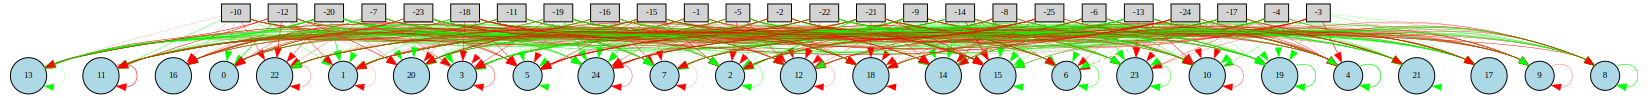

In [ ]:
draw_net(global_config, global_winner, filename="graph", view=True)

In [ ]:
import pickle
from google.colab import files

with open('winner-recurrent-trial-2', 'wb') as f:
  pickle.dump(global_winner, f)

with open('body_matrix', 'wb') as f:
  pickle.dump(body_matrix, f)

In [ ]:
files.download('winner-recurrent-trial-2')
files.download('config-recurrent-trial-2')
files.download('body_matrix')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for genome, generation in zip(checkpoint_genomes, generation_checkpoints):
  with open('checkpoint-genome-gen-' + str(generation), 'wb') as f:
    pickle.dump(genome, f)
    files.download('checkpoint-genome-gen-' + str(generation))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>